In [1]:
import matplotlib.pyplot as plt
import math
import operator
import torch
from functools import partial

torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

# Create Data

In [2]:
n_clusters = 6
n_samples = 250

centroids = torch.rand(n_clusters, 2)*70-35

In [3]:
torch.distributions.MultivariateNormal

torch.distributions.multivariate_normal.MultivariateNormal

In [4]:
def sample(mean):
    return torch.distributions.MultivariateNormal(mean, torch.diag(torch.tensor([5., 5]))).sample((n_samples,))

In [5]:
X = torch.zeros((n_samples*n_clusters, 2))
for i, centroid in enumerate(centroids):
    X[i*n_samples:(i+1)*n_samples] = sample(centroid)

In [6]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

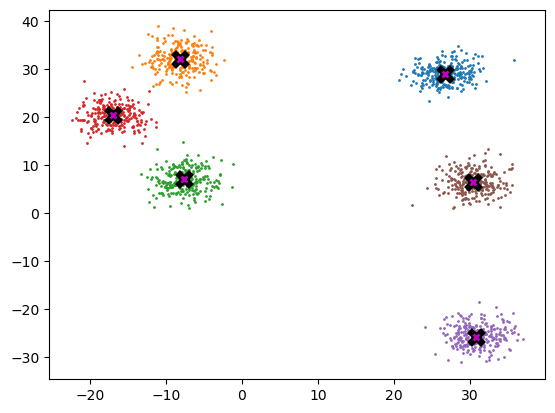

In [7]:
plot_data(centroids, X, n_samples)

# Implement mean-shift clustering line by line

In [8]:
x = X[0] ; x-X

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        ...,
        [-4.568, 17.025],
        [-3.151, 22.389],
        [-4.964, 21.040]])

In [9]:
dists = torch.sqrt(((x-X)**2).sum(1)) ; dists

tensor([ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617])

In [10]:
torch.equal(
    torch.sqrt(torch.einsum("ij->i", (x-X)**2)),
    dists
), torch.equal(
    torch.sqrt(torch.einsum("ij, ij->i", (x-X), (x-X))),
    dists
)

(True, True)

In [11]:
def gaussian(x, mean, std):
    return torch.exp(-0.5*((x-mean)/std)**2) / (math.sqrt(2 * math.pi) * std)

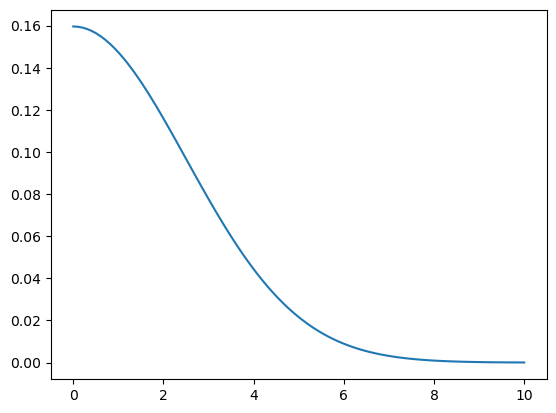

In [12]:
def plot(f):
    x = torch.linspace(0, 10, 100)
    plt.plot(x, f(x))
plot(partial(gaussian, mean=0, std=2.5))

In [13]:
kernel = partial(gaussian, mean=0, std=2.5)

In [14]:
weights = kernel(dists); weights

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [15]:
x_next = (weights[:, None] * X).sum(0) / weights.sum()

In [16]:
x, x_next, centroids[0]

(tensor([26.204, 26.349]), tensor([26.440, 28.038]), tensor([26.759, 29.050]))

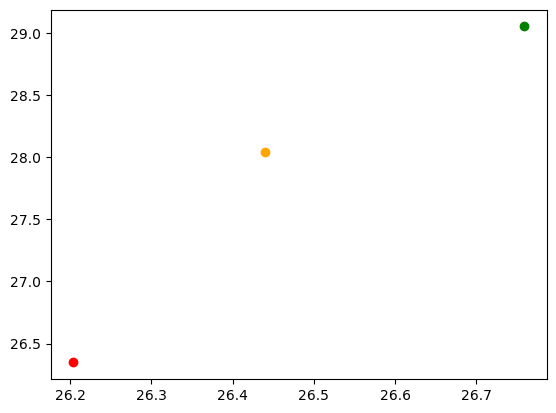

In [17]:
# we're moving in the right direction!
fig, ax = plt.subplots()
ax.scatter(*x, c="red")
ax.scatter(*x_next, c="orange")
ax.scatter(*centroids[0], c="green")
plt.show()

In [18]:
def one_step(X):
    X_next = torch.zeros_like(X)
    for i, x in enumerate(X):
        dists = torch.sqrt(((x-X)**2).sum(1))
        weights = kernel(dists)
        # print((weights[:, None] * X).shape)
        X_next[i] = (weights[:, None] * X).sum(0) / weights.sum()
    X[:] = X_next # need the [:]!!!

In [19]:
from matplotlib.animation import FuncAnimation

In [20]:
def do_one(d):
    if d: one_step(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [21]:
from IPython.display import HTML

In [22]:
fig, ax = plt.subplots()
anim = FuncAnimation(fig, do_one, 5, interval=500)
plt.close()

HTML(anim.to_jshtml())

# Removing the for loop with pytorch